In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
# from matplotlib.patches import Rectangle
# from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import os
%matplotlib inline

# Question 1

In [2]:
execfile('../../matplotlibrc.py')

In [3]:
def read_cp(folder, prefix):
    filename = '_'.join([prefix, 'airfoilpressure.dat'])
    filepath = os.path.join('dat', folder, filename)
    x, cp = np.genfromtxt(filepath, unpack=True)
    return x, cp

def read_cld(folder, prefix):
    filename = '_'.join([prefix, 'cl-cd.dat'])
    filepath = os.path.join('dat', folder, filename)
    cl, cd = map(float, open(filepath).read().split('\n')[:2])
    return cl, cd

In [27]:
CP_XLIMS = [-0.05, 1.05]
def cp_format(ax):
    ax.set_xlim(*CP_XLIMS)
    ax.set_xlabel('Relative position')
    ax.set_ylabel('Pressure coefficient')
    ax.set_title('Pressure coefficient over airfoil')
    
def polar_format(ax, do_y=True):
    if do_y:
        ax.set_ylabel('Lift coefficient')
    ax.set_xlabel('Drag coefficient')
    ax.set_title('Drag polar')

In [5]:
def mk_line(vals):
    return ' & '.join(vals) + '\\\\'

def mk_table(head, lines, foot):
    body = '\n'.join(lines)
    return '\n'.join([head, body, foot])

In [28]:
# Table
tablehead = r'''\begin{tabular}{@{}r c c | c c @{}}
\toprule
Panels & $C_L$ & $C_D$ & $\Delta C_L$ (%) & $\Delta C_D$ (%)\\
\midrule'''
tablefoot = r'''\bottomrule
\end{tabular}'''

panels = np.arange(20, 110, 10, dtype=int)
folder = 'q1'
lines = []
prefix = '{:d}panels'.format(100)
cl_100, cd_100 = read_cld(folder, prefix)
for panel in panels:
    prefix = '{:d}panels'.format(panel)
    cl, cd = read_cld(folder, prefix)
    cl_diff = np.abs(cl - cl_100)/cl_100*100
    cd_diff = np.abs(cd - cd_100)/cd_100*100
    line = mk_line([str(panel), '%.5f'%cl, '%.4f'%cd, '%.2f'%cl_diff, '%.2f'%cd_diff])
    lines.append(line)

table = mk_table(tablehead, lines, tablefoot)
print(table)
open(os.path.join('tex', 'tableq1.tex'),'w').write(table)

\begin{tabular}{@{}r c c | c c @{}}
\toprule
Panels & $C_L$ & $C_D$ & $\Delta C_L$ (%) & $\Delta C_D$ (%)\\
\midrule
20 & 0.44883 & 0.0078 & 6.13 & 8.33\\
30 & 0.46731 & 0.0080 & 2.27 & 11.11\\
40 & 0.47245 & 0.0080 & 1.19 & 11.11\\
50 & 0.47464 & 0.0073 & 0.74 & 1.39\\
60 & 0.47592 & 0.0073 & 0.47 & 1.39\\
70 & 0.47677 & 0.0073 & 0.29 & 1.39\\
80 & 0.47737 & 0.0072 & 0.16 & 0.00\\
90 & 0.47782 & 0.0072 & 0.07 & 0.00\\
100 & 0.47816 & 0.0072 & 0.00 & 0.00\\
\bottomrule
\end{tabular}


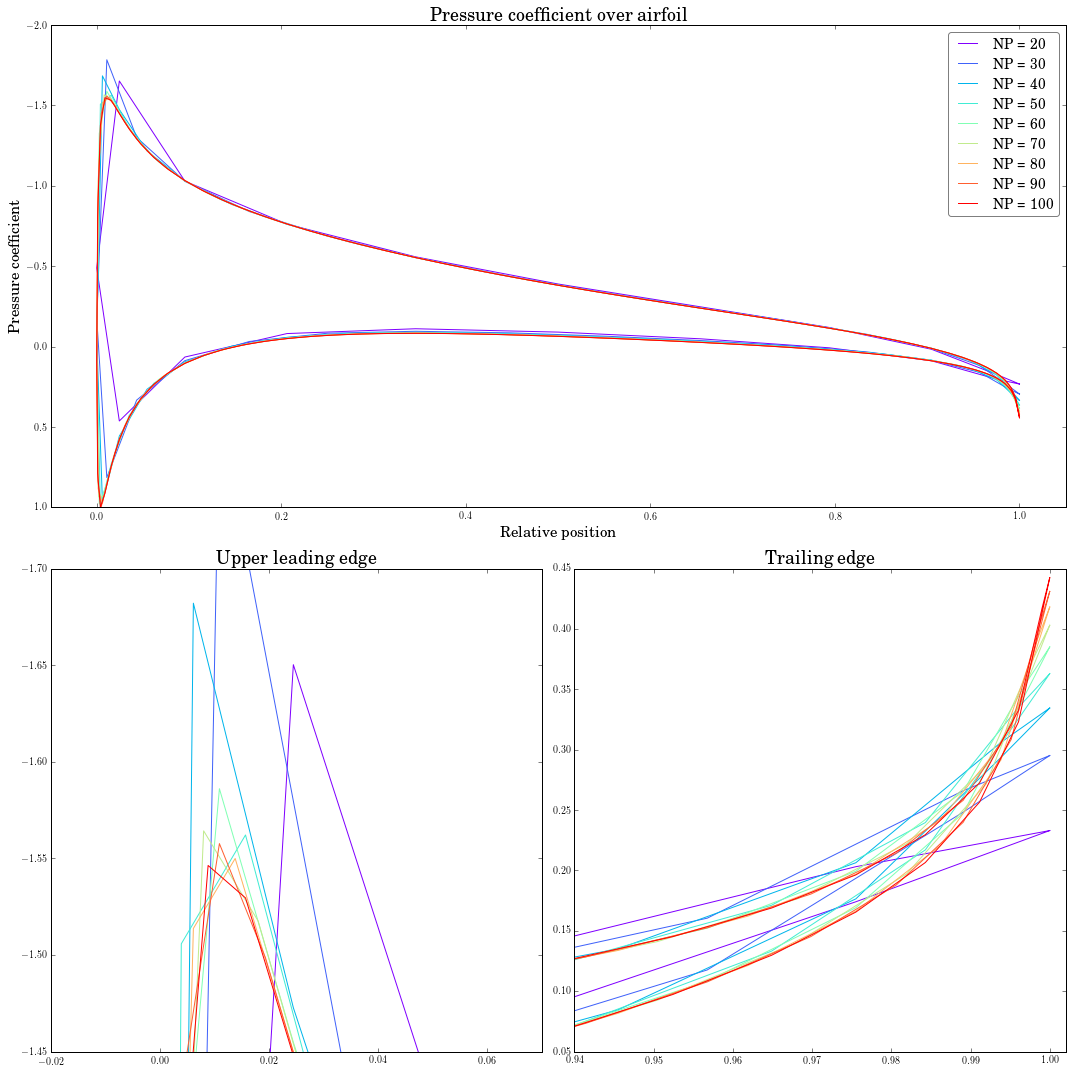

In [29]:
# Cp Plot
fig = plt.figure(figsize=(15, 15))
G = gridspec.GridSpec(2, 2)
ax_top = plt.subplot(G[0,:])
ax_le = plt.subplot(G[1,0])
ax_te = plt.subplot(G[1, 1])
panels = np.arange(20, 110, 10, dtype=int)
folder = 'q1'
cm_subsection = np.linspace(0, 1, len(panels))
colors = [ cm.rainbow(x) for x in cm_subsection ]
for panel, color in zip(panels, colors):
    prefix = '{:d}panels'.format(panel)
    x, cp = read_cp(folder, prefix)
    ax_top.plot(x, cp, label='NP = %d'%panel, color=color)
    ax_le.plot(x, cp, color=color)
    ax_te.plot(x, cp, color=color)
    

for ax in [ax_top, ax_le, ax_te]:
    ax.invert_yaxis()
cp_format(ax_top)
ax_le.set_xlim(-0.02, 0.07)
ax_le.set_ylim(-1.45, -1.7)
ax_te.set_xlim(0.94, 1.002)
ax_te.set_ylim(0.05, 0.45)
ax_le.set_title('Upper leading edge')
ax_te.set_title('Trailing edge')
ax_top.legend()
fig.tight_layout()
fig.savefig('tex/figs/q1.pdf', dpi=400)
plt.show()

# Question 3

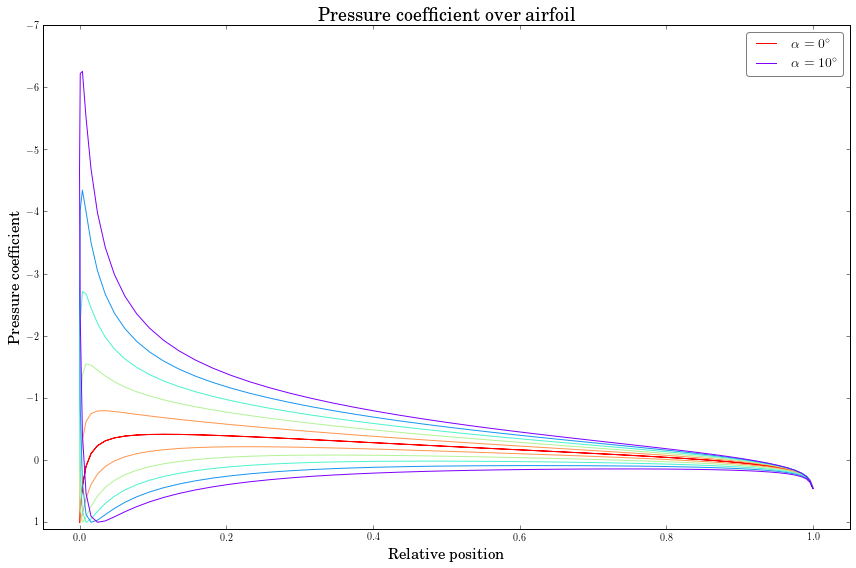

In [30]:
fig, ax = plt.subplots(figsize=(12, 8))
folder = 'q3'
angles = [0, 2, 4, 6, 8, 10]
cm_subsection = np.linspace(0, 1, len(angles))
colors = [ cm.rainbow(x) for x in cm_subsection ]
for angle, color in zip(angles, reversed(colors)):
    prefix = '{:d}alpha'.format(angle)
    x, cp = read_cp(folder, prefix)
    if angle == 0 or angle == 10:
        label=r'$\alpha = %d^\circ$'%angle
    else:
        label=None
    ax.plot(x, cp, label=label, color=color)
    
ax.legend()
cp_format(ax)
ax.set_ylim(1.1, -7)
# ax.invert_yaxis()
fig.tight_layout()
fig.savefig('tex/figs/q3_cp.pdf')
plt.show()

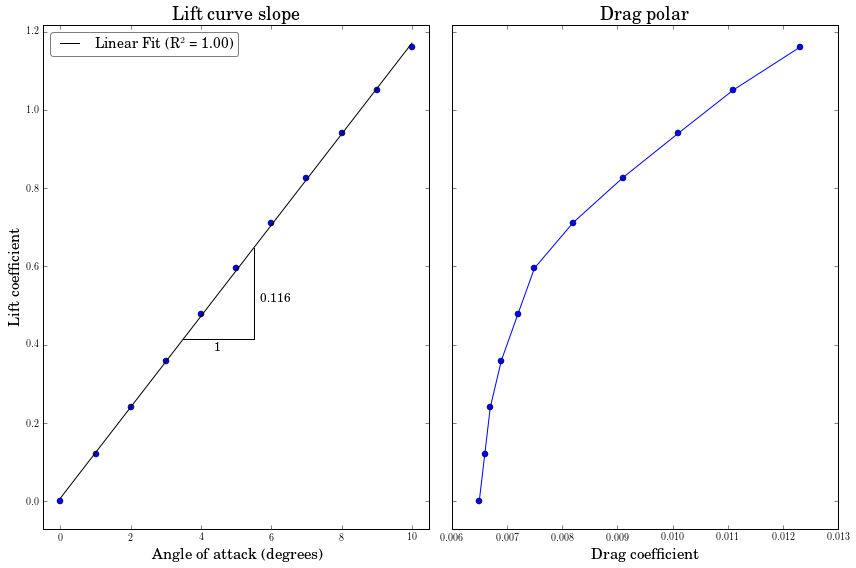

In [32]:
def fit(x, y):
    coefs = np.polyfit(x, y, 1)
    slope = coefs[0]
    poly = np.poly1d(coefs)
    mean = np.average(y)
    f = poly(x)
    sstot = np.sum((y - mean)**2)
    ssres = np.sum((y - f)**2)
    r2 = 1 - ssres/sstot
    return poly, slope, r2

folder = 'q3'
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12, 8))
angles = np.arange(0, 11, 1)
CL = np.zeros_like(angles, dtype=float)
CD = np.zeros_like(angles, dtype=float)
for i, angle in enumerate(angles):
    prefix = '{:d}alpha'.format(angle)
    cl, cd = map(float, read_cld(folder, prefix))
    CL[i] = cl
    CD[i] = cd

ax1.plot(angles, CL, 'bo')

# Fit stuff
poly, slope, r2 = fit(angles, CL)
line = poly(angles)
ax1.plot(angles, line, 'k-', label='Linear Fit (R$^2$ = %.2f)'%r2)
a = 3.5
b = 5.5
ya = poly([a])
yb = poly([b])
line1x = [a, b]
line1y = [ya, ya]
line2x = [b,b]
line2y = [ya, yb]
ax1.plot(line1x, line1y, 'k-')
ax1.plot(line2x, line2y, 'k-')
ax1.annotate('1', [0.5*(a+b), ya*0.93], ha='center', fontsize=12)
ax1.annotate('%.3f' % slope, [b*1.03, 0.49*(ya + yb)], va='center', fontsize=12)


ax1.legend()
ax1.set_xlabel('Angle of attack (degrees)')
ax1.set_ylabel('Lift coefficient')
ax1.set_title('Lift curve slope')
ax1.set_xlim(-0.5, angles.max()*1.05)
ax1.set_ylim(-0.07, CL.max()*1.05)
ax2.plot(CD, CL, 'b-o')

polar_format(ax2, False)
fig.tight_layout()
fig.savefig('tex/figs/q3_lift.pdf')
plt.show()

# Question 4

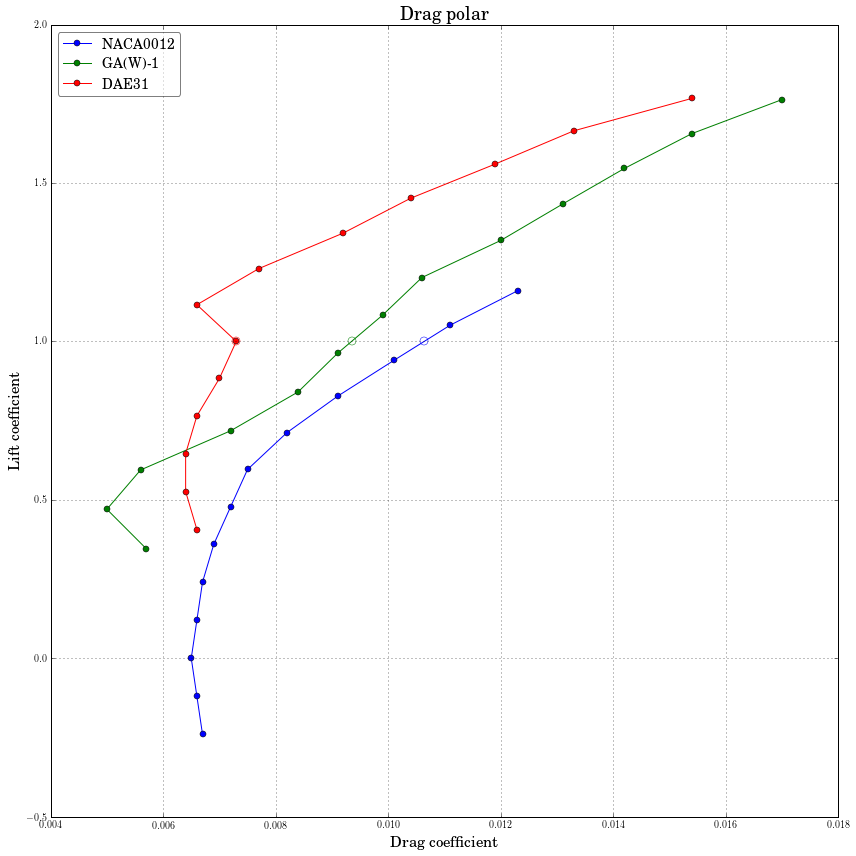

\begin{tabular}{@{} r c @{}}
\toprule
Airfoil & $C_D$ at $C_L=1$\\
\midrule
NACA0012 & 0.0106\\
GA(W)-1 & 0.0093\\
DAE31 & 0.0073\\
\bottomrule
\end{tabular}


In [33]:
def find_cd_at_1(CL, CD):
    just_above = (CL >= 1.0).argmax()
    nearest = [just_above-1, just_above]
    coefs = np.polyfit(CL[nearest], CD[nearest], 1)
    poly = np.poly1d(coefs)
    return poly(1.0)

tablehead = r'''\begin{tabular}{@{} r c @{}}
\toprule
Airfoil & $C_D$ at $C_L=1$\\
\midrule'''
tablefoot = r'''\bottomrule
\end{tabular}'''
lines = []

folder = 'q4'
airfoils = [('naca','NACA0012'), ('ga', 'GA(W)-1'), ('dae', 'DAE31')]
angles = np.arange(-2, 11, 1, dtype=int)

fig, ax = plt.subplots(figsize=(12, 12))
colors = ['b', 'g', 'r']
for color, airfoil in zip(colors, airfoils):
    CL = np.zeros_like(angles, dtype=float)
    CD = np.zeros_like(angles, dtype=float)
    for i, angle in enumerate(angles):
        prefix = '%s_%d' % (airfoil[0], angle)
        cl, cd = map(float, read_cld(folder, prefix))
        CL[i] = cl
        CD[i] = cd
    
    ax.plot(CD, CL, '-o', label=airfoil[1], color=color)
    cd = find_cd_at_1(CL, CD)
    ax.plot(cd, 1.0, 'o', mfc='none', mec=color, ms=8)
    line = mk_line([airfoil[1], '%.4f'%cd])
    lines.append(line)

ax.legend(numpoints=1, loc='upper left')
polar_format(ax)
ax.grid()
fig.tight_layout()
fig.savefig('tex/figs/q4_polars.pdf')
plt.show()

table = mk_table(tablehead, lines, tablefoot)
print(table)
open('tex/tableq4.tex', 'w').write(table)

In [34]:
def read_cf(folder, prefix):
    X = []
    CF = []
    for surf in ['upper', 'lower']:
        filename = '_'.join([prefix, '%s_cf.dat'%surf])
        filepath = os.path.join('dat', folder, filename)
        x, cf = np.genfromtxt(filepath, unpack=True, delimiter=',')
        X.append(x)
        CF.append(cf)
    return X, CF

def read_transition(folder, prefix):
    filename = '_'.join([prefix, 'transition.dat'])
    filepath = os.path.join('dat', folder, filename)
    return open(filepath).readlines()[:2]

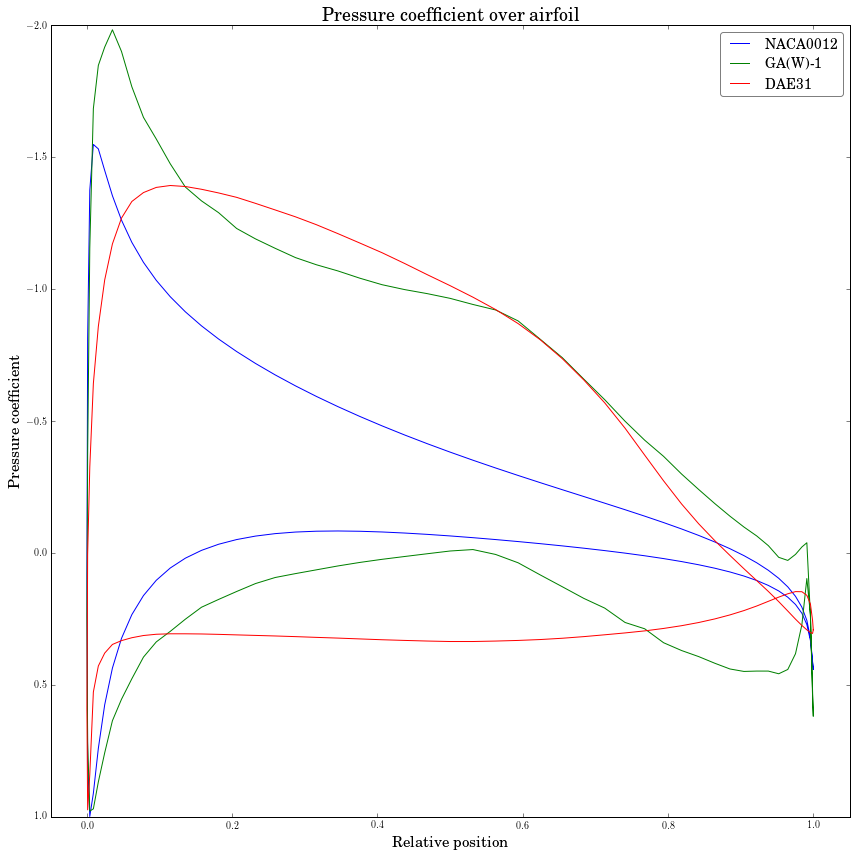

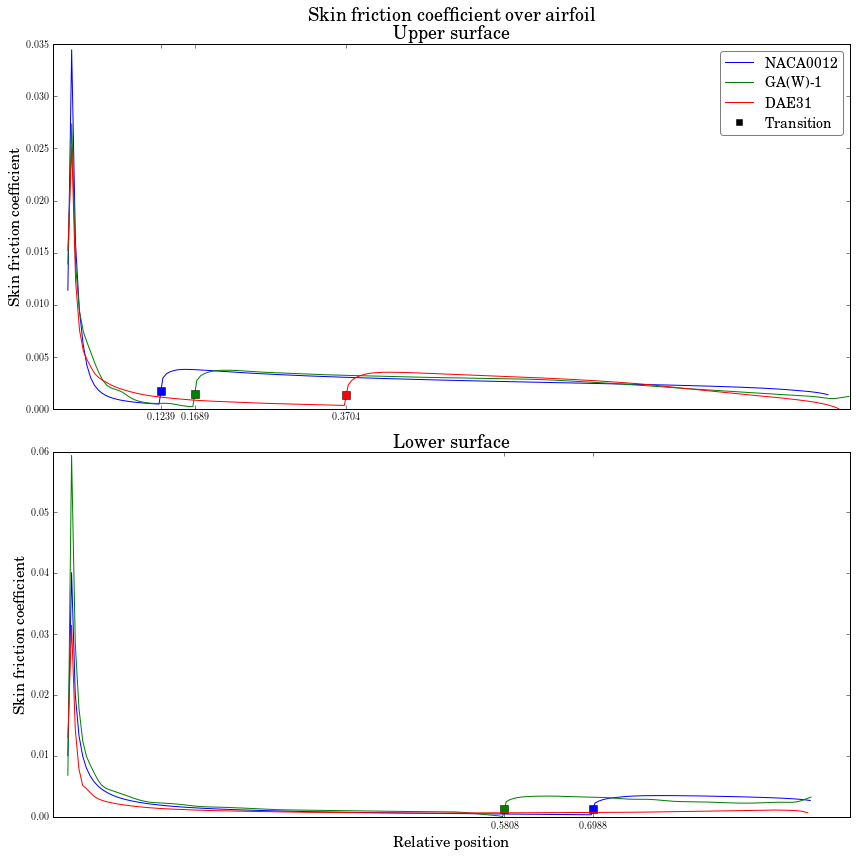

In [47]:
def avg(a, idx):
    return 0.5*(a[idx] + a[idx+1])

fig1, ax1 = plt.subplots(figsize=(12, 12))
fig2, axes = plt.subplots(nrows=2, figsize=(12, 12))
ax21, ax22 = axes
angle = 4
transitions = []
for color, airfoil in zip(colors, airfoils):
    prefix = '%s_%d' % (airfoil[0], angle)
    x, cp = read_cp(folder, prefix)
    ax1.plot(x, cp, '-', label=airfoil[1], color=color)
    X, CF = read_cf(folder, airfoil[0])
    ax21.plot(X[0], CF[0], label=airfoil[1], color=color)
    ax22.plot(X[1], CF[1], color=color)
    
    # Find transition
    temp = []
    for i in range(2):
        if airfoil[0] == 'dae' and i == 1:
            continue
        x = X[i][5:]
        cf = CF[i][5:]
        ax = axes[i]
        diff = cf[1:] - cf[:-1]
        loc = diff.argmax()
        xloc = avg(x, loc)
        temp.append(xloc)
        ax.plot(xloc, avg(cf, loc), 's', color=color, ms=8)
    transitions.append(temp)
    
ax1.legend()
cp_format(ax1)
ax1.invert_yaxis()
fig1.tight_layout()
fig1.savefig('tex/figs/q4_cp.pdf')

ax21.plot(-1.0, 0.0, 'ks', ms=6, label='Transition')
ax21.legend(numpoints=1)
ax21.set_title('Skin friction coefficient over airfoil\nUpper surface')
ax22.set_title('Lower surface')
ax22.set_xlabel('Relative position')
ax21.set_ylabel('Skin friction coefficient')
ax22.set_ylabel('Skin friction coefficient')
ax21.set_xlim(-0.02, 1.04)
ax22.set_xlim(-0.02, 1.04)
ax21.set_xticks([t[0] for t in transitions])
ax22.set_xticks([t[1] for t in transitions[:2]])
fig2.tight_layout()
fig2.savefig('tex/figs/q4_cf.pdf')

plt.show()

# Question 5

In [67]:
nearest = np.abs()
x[nearest-1:nearest+2]

array([ 0.37565506,  0.3454915 ,  0.31593772])

In [68]:
print(trans)

0.3736


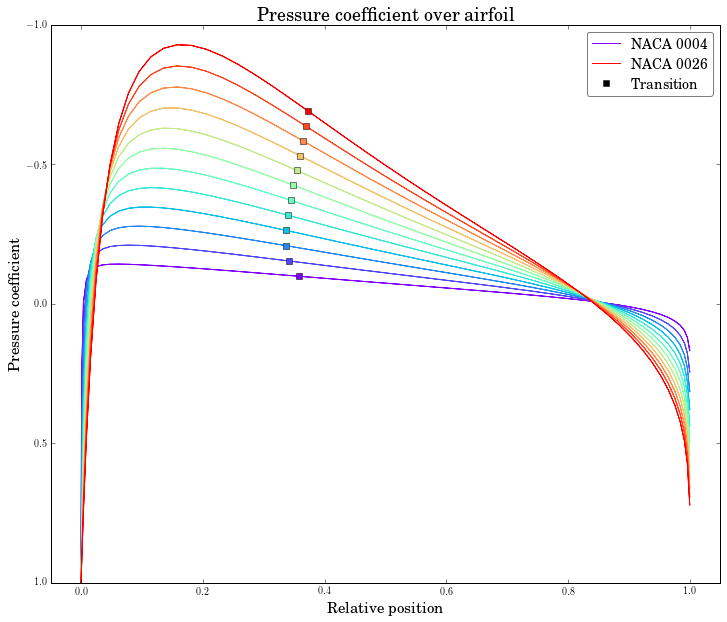

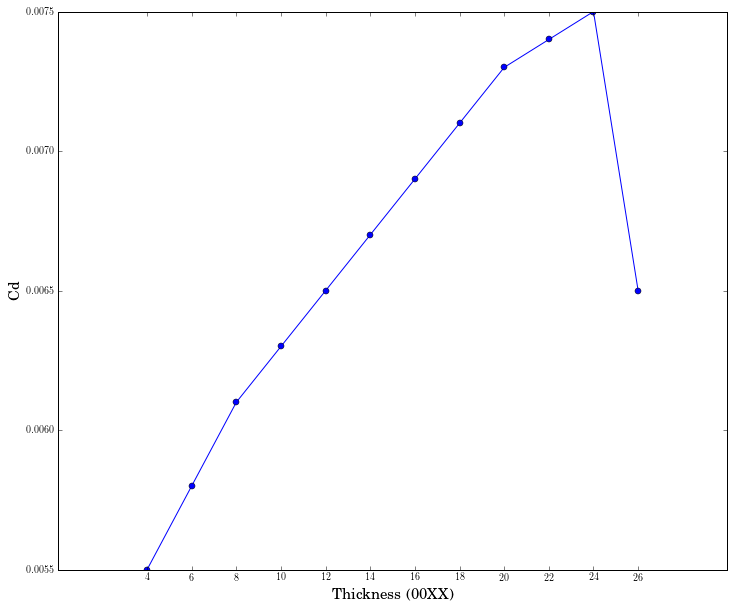

In [79]:
def find_cp_at_trans(x, cp, trans, surface='upper'):
    if surface == 'upper':
        a = 0
        b = 51
    else:
        a = 51
        b = len(x) + 1
    x_surf = x[a:b]
    cp_surf = cp[a:b]
    closest = np.abs(x_surf - trans).argmin()
    nearest = [closest-1, closest]
    coefs = np.polyfit(x_surf[nearest], cp_surf[nearest], 1)
    poly = np.poly1d(coefs)
    return poly(trans)

folder = 'q5'

#Thickness
fig1, ax1 = plt.subplots(figsize=(12, 10))
fig2, ax2 = plt.subplots(figsize=(12, 10))
T = np.arange(4, 28, 2, dtype=int)
CD = []
cm_subsection = np.linspace(0, 1, len(T))
colors = [ cm.rainbow(x) for x in cm_subsection ]
for t, color in zip(T, colors):
    prefix = '00%02d' % t
    x, cp = read_cp(folder, prefix)
    cl, cd = read_cld(folder, prefix)
    CD.append(cd)
    if t == 4 or t == 26:
        label = 'NACA ' + prefix
    else:
        label=None
    ax1.plot(x, cp, label=label, color=color)
    trans = float(read_transition(folder, prefix)[0].strip().split()[-1])/100
    cp_trans = find_cp_at_trans(x, cp, trans)
    ax1.plot(trans, cp_trans, 's', color=color, ms=6)
    
ax1.plot(-1.0, 0.0, 'ks', ms=6, label='Transition')
ax1.legend(numpoints=1)
ax1.invert_yaxis()
cp_format(ax1)
ax2.plot(T, CD, 'b-o')
ax2.set_xlabel('Thickness (00XX)')
ax2.set_ylabel('Cd')
ax2.set_xticks(T)

fig1.savefig('tex/figs/q5_thickness_cp.pdf')
fig2.savefig('tex/figs/q5_thickness_polar.pdf')

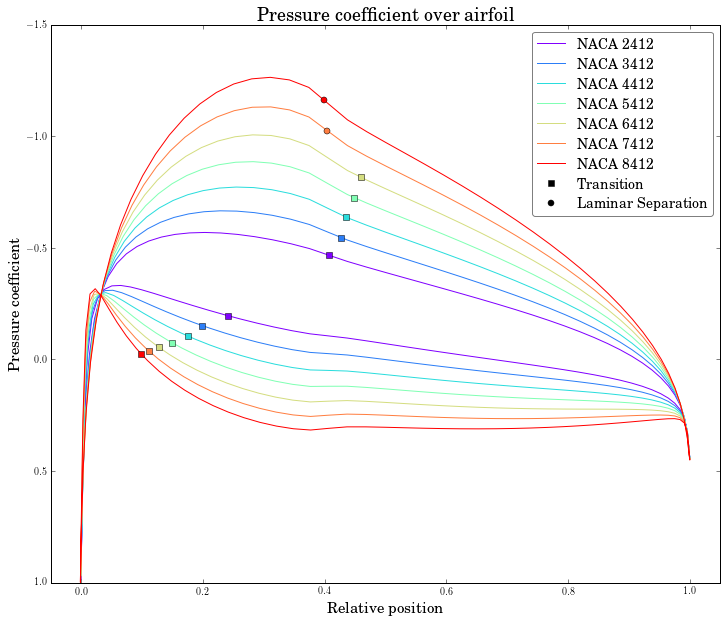

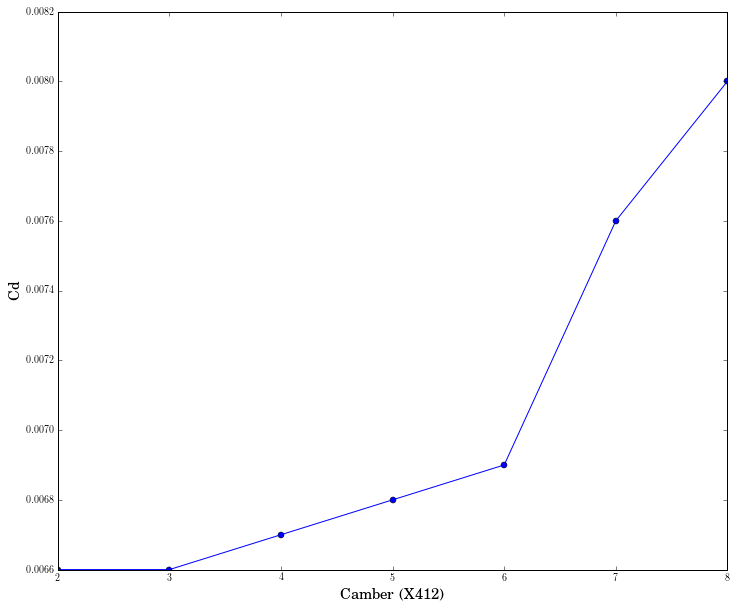

In [82]:
folder = 'q5'

#Thickness
fig1, ax1 = plt.subplots(figsize=(12, 10))
fig2, ax2 = plt.subplots(figsize=(12, 10))
C = np.arange(2, 9, 1, dtype=int)
CD = []
cm_subsection = np.linspace(0, 1, len(C))
colors = [ cm.rainbow(x) for x in cm_subsection ]
for camber, color in zip(C, colors):
    prefix = '%d412' % camber
    x, cp = read_cp(folder, prefix)
    cl, cd = read_cld(folder, prefix)
    CD.append(cd)
    label = 'NACA ' + prefix
    ax1.plot(x, cp, label=label, color=color)
    lines = read_transition(folder, prefix)
    for line, surf in zip(lines, ['upper', 'lower']):
        name, trans = line.split(' : ')[1].split(' at ')
        trans = float(trans)/100
        cp_trans = find_cp_at_trans(x, cp, trans, surf)
        if name == 'Transition':
            style = 's'
        elif name == 'Laminar Separation':
            style = 'o'
        else:
            print('Woops! %s' % name)
            print prefix
            
        ax1.plot(trans, cp_trans, style, color=color, ms=6)
        
ax1.plot(-1.0, 0.0, 'ks', ms=6, label='Transition')
ax1.plot(-1.0, 0.0, 'ko', ms=6, label='Laminar Separation')
ax1.legend(numpoints=1)
ax1.invert_yaxis()
cp_format(ax1)
ax2.plot(C, CD, 'b-o')
ax2.set_xlabel('Camber (X412)')
ax2.set_ylabel('Cd')

fig1.savefig('tex/figs/q5_camber_cp.pdf')
fig2.savefig('tex/figs/q5_camber_polar.pdf')

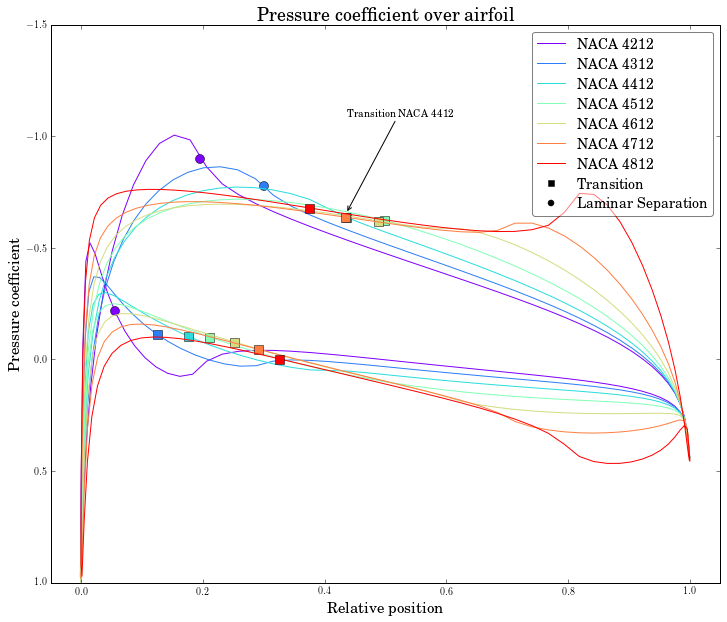

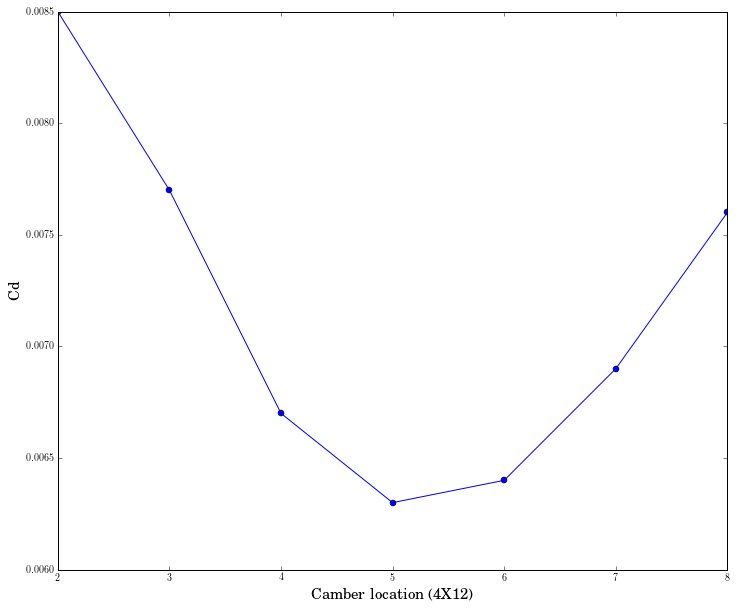

In [110]:
def add_text(ax, trans, cp_trans):
    ax.annotate('Transition NACA 4412', xy=(trans, cp_trans*1.03), xycoords='data',
            xytext=(0.6, 0.85), textcoords='axes fraction',
            arrowprops=dict(arrowstyle='->', facecolor='black'),
            horizontalalignment='right', verticalalignment='top',
            )

folder = 'q5'

#Thickness
fig1, ax1 = plt.subplots(figsize=(12, 10))
fig2, ax2 = plt.subplots(figsize=(12, 10))
C = np.arange(2, 9, 1, dtype=int)
CD = []
cm_subsection = np.linspace(0, 1, len(C))
colors = [ cm.rainbow(x) for x in cm_subsection ]
for camber_loc, color in zip(C, colors):
    prefix = '4%d12' % camber_loc
    x, cp = read_cp(folder, prefix)
    cl, cd = read_cld(folder, prefix)
    CD.append(cd)
    label = 'NACA ' + prefix
    ax1.plot(x, cp, label=label, color=color)
#     if camber_loc != 4:
#         continue
    lines = read_transition(folder, prefix)
    for line, surf in zip(lines, ['upper', 'lower']):
        name, trans = line.split(' : ')[1].split(' at ')
        trans = float(trans)/100
        cp_trans = find_cp_at_trans(x, cp, trans, surf)
        if name == 'Transition':
            style = 's'
        elif name == 'Laminar Separation':
            style = 'o'
        else:
            print('Woops! %s' % name)
            print prefix
    
        ax1.plot(trans, cp_trans, style, color=color, ms=9)
        
        if surf == 'upper' and camber_loc == 4:
            add_text(ax1, trans, cp_trans)
        
ax1.plot(-1.0, 0.0, 'ks', ms=6, label='Transition')
ax1.plot(-1.0, 0.0, 'ko', ms=6, label='Laminar Separation')
ax1.legend(numpoints=1)
ax1.invert_yaxis()
cp_format(ax1)
ax2.plot(C, CD, 'b-o')
ax2.set_xlabel('Camber location (4X12)')
ax2.set_ylabel('Cd')

fig1.savefig('tex/figs/q5_camberloc_cp.pdf')
fig2.savefig('tex/figs/q5_camberloc_polar.pdf')